# Expungability Hypothetical: Elimination of Petition Eligibility (Converting Petition to Automatic)

In [ ]:
import sqlalchemy as sa
from sqlalchemy import create_engine
import psycopg2 as db
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import sidetable
pd.set_option('display.max_colwidth', None)

In [4]:
## loading from db
postPass=os.environ["POSTGRES_PASS"]
try:
    conn = db.connect(host='localhost', database='expunge', user='jupyter', password=postPass, port='5432')
except:
    print("I am unable to connect to the database") 

cur = conn.cursor()
try:
    tables=cur.execute("select * from pg_catalog.pg_tables WHERE schemaname != 'information_schema' AND schemaname != 'pg_catalog';")
    print(cur)
    
except:
    print("I can't drop our test database!")

<cursor object at 0x7f084cc81650; closed: 0>


In [5]:
## grabbing court data - limited to 500
myquery = """
    SELECT * FROM public.expunge LIMIT 500
    """
courtdata = pd.read_sql(myquery, con=conn)

In [6]:
courtdata.head()
courtdata.columns

Index(['person_id', 'HearingDate', 'CodeSection', 'codesection', 'ChargeType',
       'chargetype', 'Class', 'DispositionCode', 'disposition', 'Plea', 'Race',
       'Sex', 'fips', 'convictions', 'arrests', 'felony10', 'sevenyear',
       'tenyear', 'within7', 'within10', 'class1_2', 'class3_4', 'expungable',
       'old_expungable', 'expungable_no_lifetimelimit', 'reason', 'sameday',
       'lifetime'],
      dtype='object')

In [19]:
conditionals = [
    courtdata["expungable"] == "Petition",
    courtdata["expungable"] == "Petition (pending)",
    (courtdata["expungable"] != "Petition (pending)") & (courtdata["expungable"] != "Petition")]

labels = ["Automatic", "Automatic (pending)", courtdata["expungable"]]

courtdata["expungable_no_petition"] = np.select(conditionals, labels)
courtdata.head()

,person_id,HearingDate,CodeSection,codesection,ChargeType,chargetype,Class,DispositionCode,disposition,Plea,...,within10,class1_2,class3_4,expungable,old_expungable,expungable_no_lifetimelimit,reason,sameday,lifetime,expungable_no_petition
0,292031000000162,2017-08-18,18.2-91,covered elsewhere,Felony,Felony,O,Dismissed,Dismissed,NA,...,TRUE,FALSE,FALSE,Petition,TRUE,Petition,Dismissal of felony charges,FALSE,FALSE,Automatic
1,195240000000019,2011-12-14,18.2-250,covered elsewhere,Felony,Felony,5,Nolle Prosequi,Dismissed,NA,...,TRUE,FALSE,FALSE,Petition,TRUE,Petition,Dismissal of felony charges,FALSE,FALSE,Automatic
2,34090000000256,2014-12-17,18.2-95,covered elsewhere,Felony,Felony,U,Nolle Prosequi,Dismissed,NA,...,TRUE,FALSE,FALSE,Petition,TRUE,Petition,Dismissal of felony charges,FALSE,FALSE,Automatic
3,34091000000145,2013-01-24,19.2-306,covered elsewhere,Felony,Felony,U,Dismissed,Dismissed,NA,...,TRUE,FALSE,FALSE,Petition,TRUE,Petition,Dismissal of felony charges,FALSE,FALSE,Automatic
4,244010000000958,2019-05-29,18.2-248,covered elsewhere,Felony,Felony,U,Nolle Prosequi,Dismissed,NA,...,TRUE,FALSE,FALSE,Petition,TRUE,Petition,Dismissal of felony charges,FALSE,FALSE,Automatic


In [20]:
courtdata.tail()

,person_id,HearingDate,CodeSection,codesection,ChargeType,chargetype,Class,DispositionCode,disposition,Plea,...,within10,class1_2,class3_4,expungable,old_expungable,expungable_no_lifetimelimit,reason,sameday,lifetime,expungable_no_petition
495,292030000000048,2011-05-26,46.2-324,covered elsewhere,Misdemeanor,Misdemeanor,NA,Nolle Prosequi,Dismissed,NA,...,TRUE,FALSE,FALSE,Petition,TRUE,Petition,"Dismissal of misdemeanor charges, but with arrests or charges in the past 3 years",FALSE,FALSE,Automatic
496,292030000000048,2011-05-26,B.46.2-301,covered elsewhere,Misdemeanor,Misdemeanor,1,Guilty,Conviction,Guilty,...,TRUE,FALSE,FALSE,Not eligible,FALSE,Not eligible,Conviction or deferred dismissal of misdemeanor charges that are excluded from expungement by 19.2-392.12,FALSE,FALSE,Not eligible
497,292030000000048,2011-05-26,46.2-938,covered elsewhere,Misdemeanor,Misdemeanor,1,Dismissed,Dismissed,NA,...,TRUE,FALSE,FALSE,Petition,TRUE,Petition,"Dismissal of misdemeanor charges, but with arrests or charges in the past 3 years",FALSE,FALSE,Automatic
498,292030000000048,2015-08-11,B.46.2-301,covered elsewhere,Misdemeanor,Misdemeanor,NA,Guilty In Absentia,Conviction,Tried In Absentia,...,TRUE,FALSE,FALSE,Not eligible,FALSE,Not eligible,Conviction or deferred dismissal of misdemeanor charges that are excluded from expungement by 19.2-392.12,FALSE,FALSE,Not eligible
499,292030000000048,2017-02-23,18.2-250.1,covered in 19.2-392.6 - B,Misdemeanor,Misdemeanor,U,Guilty,Conviction,Nolo Contendere,...,TRUE,FALSE,FALSE,Not eligible,FALSE,Not eligible,"Conviction of misdemeanor charges that are not excluded from expungement by 19.2-392.12, but with convictions of another kind within 7 years from disposition date",FALSE,FALSE,Not eligible


# Graph 1: General Expungability Graphs

### Expungability without Petition

In [39]:
# percentages without petition
df_percentages_no_petition = pd.DataFrame(courtdata.groupby("expungable_no_petition").size(), columns=['Count'])
df_percentages_no_petition['Cumlative_Percent'] = 100*(df_percentages_no_petition.Count.cumsum() / df_percentages_no_petition.Count.sum())
df_percentages_no_petition['Cumlative_Count'] = df_percentages_no_petition.Count.cumsum()
df_percentages_no_petition['Percentage'] = df_percentages_no_petition.Count.apply(lambda x: x/df_percentages_no_petition['Count'].sum())

df_percentages_no_petition

,Count,Cumlative_Percent,Cumlative_Count,Percentage
expungable_no_petition,,,,
Automatic,212,42.4,212,0.424
Automatic (pending),56,53.6,268,0.112
Not eligible,232,100.0,500,0.464


Text(0.5, 1.0, 'Expungability when Petition is Converted to Automatic')

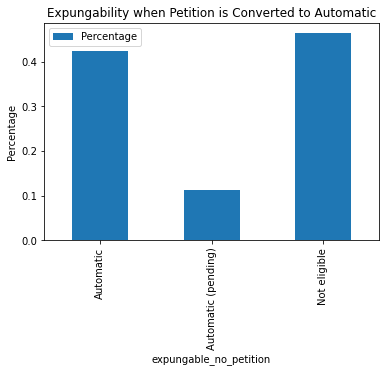

In [42]:
# Graph of Expungability without Petition
df_percentages_no_petition.plot.bar(x=None, y="Percentage")

plt.ylabel("Percentage")
plt.title("Expungability when Petition is Converted to Automatic")

### Expungability with Petition

In [44]:
# percentages with petition
df_percentages = pd.DataFrame(courtdata.groupby("expungable").size(), columns=['Count'])
df_percentages['Cumlative_Percent'] = 100*(df_percentages.Count.cumsum() / df_percentages.Count.sum())
df_percentages['Cumlative_Count'] = df_percentages.Count.cumsum()
df_percentages['Percentage'] = df_percentages.Count.apply(lambda x: x/df_percentages['Count'].sum())

df_percentages

,Count,Cumlative_Percent,Cumlative_Count,Percentage
expungable,,,,
Automatic,77,15.4,77,0.154
Automatic (pending),45,24.4,122,0.090
Not eligible,232,70.8,354,0.464
Petition,135,97.8,489,0.270
Petition (pending),11,100.0,500,0.022


Text(0.5, 1.0, 'Expungability with Petition')

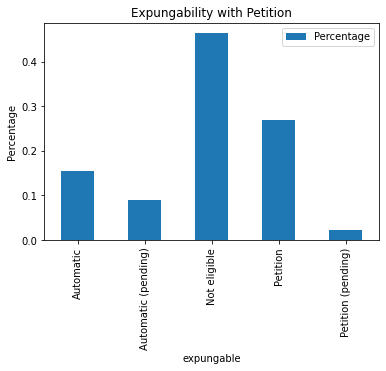

In [45]:
# Graph of Expungability with Petition
df_percentages.plot.bar(x=None, y="Percentage")

plt.ylabel("Percentage")
plt.title("Expungability with Petition")

# Graph 2: Percent Change when Petition is Converted to Automatic

In [60]:
# merge percentage tables
merged_percentages = df_percentages.reset_index()[["expungable", "Percentage"]].merge(df_percentages_no_petition.reset_index()[["expungable_no_petition", "Percentage"]], how="outer", left_on="expungable", right_on="expungable_no_petition", suffixes=["_w_pet", "_wo_pet"])
merged_percentages

# convert nan to 0
merged_percentages.fillna(0, inplace=True)
merged_percentages

# drop the expungable_no_petition column
merged_percentages.drop(columns=["expungable_no_petition"], inplace=True)
merged_percentages

# add difference column
merged_percentages["percent_difference"] = merged_percentages["Percentage_wo_pet"] - merged_percentages["Percentage_w_pet"]
merged_percentages


,expungable,Percentage_w_pet,Percentage_wo_pet,percent_difference
0,Automatic,0.154,0.424,0.270
1,Automatic (pending),0.090,0.112,0.022
2,Not eligible,0.464,0.464,0.000
3,Petition,0.270,0.000,-0.270
4,Petition (pending),0.022,0.000,-0.022


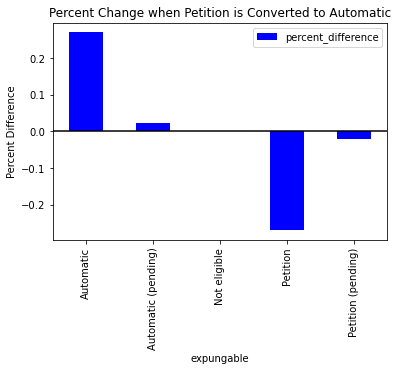

In [73]:
# Graph Percent Change when Petition is Converted to Automatic
merged_percentages.plot.bar(x="expungable", y="percent_difference", color="blue")

plt.ylabel("Percent Difference")
plt.title("Percent Change when Petition is Converted to Automatic")
plt.axhline(color="black")


# Graph 3: Expungbility by Race

###  Expunbability by Race without Petition

In [74]:
courtdata.stb.freq(['Race'])

,Race,count,percent,cumulative_count,cumulative_percent
0,White (Non-Hispanic),274,54.8,274,54.8
1,Black (Non-Hispanic),184,36.8,458,91.6
2,Other,17,3.4,475,95.0
3,Hispanic,16,3.2,491,98.2
4,Asian or Pacific Islander,6,1.2,497,99.4
5,MISSING,2,0.4,499,99.8
6,American Indian or Alaskan Native,1,0.2,500,100.0


In [75]:
replace_map = {'Black(Non-Hispanic)':'Black (Non-Hispanic)', 
               'White Caucasian(Non-Hispanic)':'White (Non-Hispanic)', 
               'Other(Includes Not Applicable.. Unknown)':'Other',
               'White Caucasian (Non-Hispanic)':'White (Non-Hispanic)',
               'Unknown (Includes Not Applicable.. Unknown)':'Other', 
               'NA':'Other',
               'Asian Or Pacific Islander':'Asian or Pacific Islander', 
               'Black (Non-Hispanic)':'Black (Non-Hispanic)', 
               'White':'White (Non-Hispanic)',
               'American Indian':'American Indian or Alaskan Native', 
               'Unknown':'Other',
               'Other (Includes Not Applicable.. Unknown)':'Other', 
               'Black':'Black (Non-Hispanic)',
               'American Indian or Alaskan Native':'American Indian or Alaskan Native',
               'American Indian Or Alaskan Native':'American Indian or Alaskan Native', 
               'Asian or Pacific Islander':'Asian or Pacific Islander'}
courtdata.Race = courtdata.Race.replace(replace_map)
courtdata.stb.freq(['Race'])

,Race,count,percent,cumulative_count,cumulative_percent
0,White (Non-Hispanic),274,54.8,274,54.8
1,Black (Non-Hispanic),184,36.8,458,91.6
2,Other,17,3.4,475,95.0
3,Hispanic,16,3.2,491,98.2
4,Asian or Pacific Islander,6,1.2,497,99.4
5,MISSING,2,0.4,499,99.8
6,American Indian or Alaskan Native,1,0.2,500,100.0


In [81]:
rowtable_no_petition = (pd.crosstab(courtdata.Race, courtdata.expungable_no_petition, normalize='index')*100).round(2).reset_index()
rowtable_no_petition

expungable_no_petition,Race,Automatic,Automatic (pending),Not eligible
0,American Indian or Alaskan Native,100.00,0.00,0.00
1,Asian or Pacific Islander,33.33,16.67,50.00
2,Black (Non-Hispanic),46.74,5.98,47.28
3,Hispanic,43.75,31.25,25.00
4,MISSING,0.00,50.00,50.00
5,Other,41.18,29.41,29.41
6,White (Non-Hispanic),39.78,12.04,48.18


Text(0, 0.5, 'Percentage')

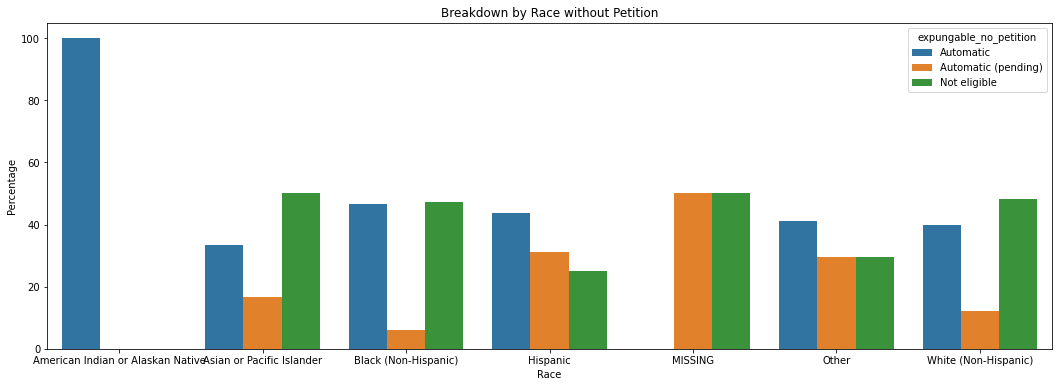

In [94]:
# graph by race without petition
barplot = pd.melt(rowtable_no_petition,
                  id_vars = ['Race'],
                  value_vars = ['Automatic', 'Automatic (pending)', 'Not eligible'])

plt.figure(figsize=(18, 6))
sns.barplot(x='Race', y='value', hue='expungable_no_petition', data=barplot).set(title="Breakdown by Race without Petition")

plt.ylabel("Percentage")

### Expunbability by Race with Petition

In [84]:
rowtable = (pd.crosstab(courtdata.Race, courtdata.expungable, normalize='index')*100).round(2).reset_index()
rowtable

expungable,Race,Automatic,Automatic (pending),Not eligible,Petition,Petition (pending)
0,American Indian or Alaskan Native,0.00,0.00,0.00,100.00,0.00
1,Asian or Pacific Islander,33.33,16.67,50.00,0.00,0.00
2,Black (Non-Hispanic),9.78,5.43,47.28,36.96,0.54
3,Hispanic,37.50,31.25,25.00,6.25,0.00
4,MISSING,0.00,50.00,50.00,0.00,0.00
5,Other,11.76,5.88,29.41,29.41,23.53
6,White (Non-Hispanic),17.88,9.85,48.18,21.90,2.19


Text(0, 0.5, 'Percentage')

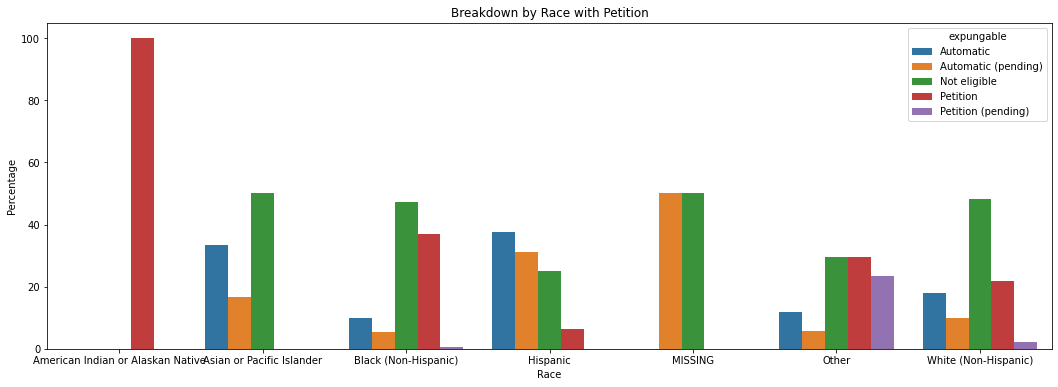

In [91]:
# graph by race with petition
barplot = pd.melt(rowtable,
                  id_vars = ['Race'],
                  value_vars = ['Automatic', 'Automatic (pending)', 'Not eligible', 'Petition', 'Petition (pending)'])

plt.figure(figsize=(18, 6))
sns.barplot(x='Race', y='value', hue='expungable', data=barplot).set(title="Breakdown by Race with Petition")

plt.ylabel("Percentage")

# Graph 4: Percent Change by Race when Petition is Converted to Automatic

In [100]:
# merge percentage tables
merged_percentages = rowtable.reset_index().merge(rowtable_no_petition.reset_index(), how="outer", on="Race", suffixes=["_w_pet", "_wo_pet"])
merged_percentages

# convert nan to 0
merged_percentages.fillna(0, inplace=True)
merged_percentages


# add columns for petition and petittio
# drop the expungable_no_petition column
merged_percentages.drop(columns=["expungable_no_petition"], inplace=True)
merged_percentages

# # add difference column
# merged_percentages["percent_difference"] = merged_percentages["Percentage_wo_pet"] - merged_percentages["Percentage_w_pet"]
# merged_percentages

,index_w_pet,Race,Automatic_w_pet,Automatic (pending)_w_pet,Not eligible_w_pet,Petition,Petition (pending),index_wo_pet,Automatic_wo_pet,Automatic (pending)_wo_pet,Not eligible_wo_pet
0,0,American Indian or Alaskan Native,0.00,0.00,0.00,100.00,0.00,0,100.00,0.00,0.00
1,1,Asian or Pacific Islander,33.33,16.67,50.00,0.00,0.00,1,33.33,16.67,50.00
2,2,Black (Non-Hispanic),9.78,5.43,47.28,36.96,0.54,2,46.74,5.98,47.28
3,3,Hispanic,37.50,31.25,25.00,6.25,0.00,3,43.75,31.25,25.00
4,4,MISSING,0.00,50.00,50.00,0.00,0.00,4,0.00,50.00,50.00
5,5,Other,11.76,5.88,29.41,29.41,23.53,5,41.18,29.41,29.41
6,6,White (Non-Hispanic),17.88,9.85,48.18,21.90,2.19,6,39.78,12.04,48.18
